## QAOA Parameter Transfer: Graph A (Baseline)

### 1. Setup
- Imports
- Graph drawing function
- Helper utils

### 2. Graph A: MaxCut Formulation
- Create graph
- Show adjacency + plot

### 3. Convert to QUBO + Ising
- Use Qiskit Optimization

### 4. QAOA Ansatz
- Create and show circuit (with measurement)
- Create circuit (no measurement) for Estimator

### 5. QAOA Optimization
- Define cost function
- Run COBYLA
- Save trajectory

### 6. Results
- Print final energy + parameters
- Plot cost vs iteration
- Save outputs (JSON/PNG)



### Setup

In [2]:
%pip install qiskit==1.1.0 qiskit_optimization==0.6.1 matplotlib networkx pylatexenc --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path

from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Estimator
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize

%matplotlib inline

### Graph A - Build and Visualize

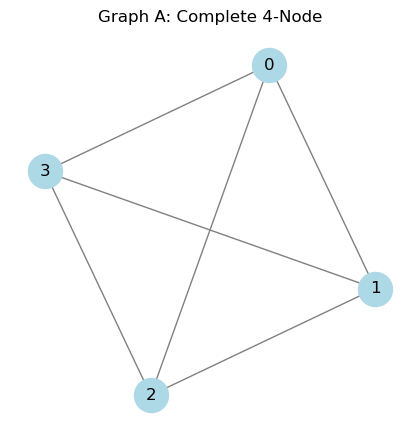

In [2]:
# Graph A: Complete 4-node
G = nx.complete_graph(4)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, edge_color='gray')
plt.title("Graph A: Complete 4-Node")
plt.show()


### Convert to QUBO

In [3]:
# Get adjacency matrix
w = nx.adjacency_matrix(G).todense()
maxcut = Maxcut(w)
qp = maxcut.to_quadratic_program()

# Convert to Ising Hamiltonian
qubit_op, offset = qp.to_ising()
print("Pauli-form Hamiltonian:\n", qubit_op)


Pauli-form Hamiltonian:
 SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### QAOA

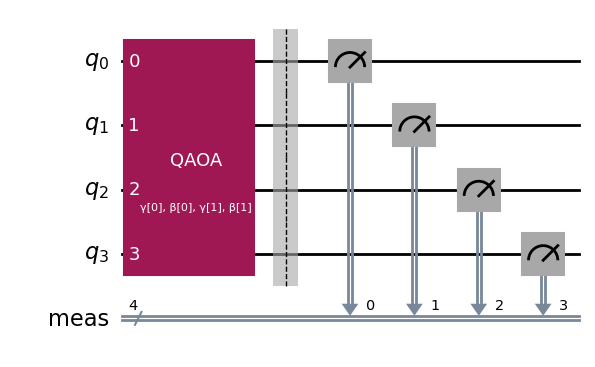

In [4]:
reps = 2
circuit = QAOAAnsatz(cost_operator=qubit_op, reps=reps)

# For display
circuit_with_measure = circuit.copy()
circuit_with_measure.measure_all()

# Draw
circuit_with_measure.draw('mpl')

### Define Estimator and Cost Function

In [5]:
estimator = Estimator()
objective_func_vals = []

def cost_func_estimator(params):
    job = estimator.run([circuit], [qubit_op], [params])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost


### Optimization

In [6]:
# Initial guess for 2-rep QAOA: [γ1, β1, γ2, β2]
init_params = [np.pi, np.pi/2] * reps

result = minimize(
    cost_func_estimator,
    x0=init_params,
    method='COBYLA',
    tol=1e-2
)

print("Final cost:", result.fun)
print("Optimal parameters:", result.x)


Final cost: -0.9876202417905122
Optimal parameters: [3.98685856 2.08272959 2.34588922 2.40023421]


### Vizualize and Save

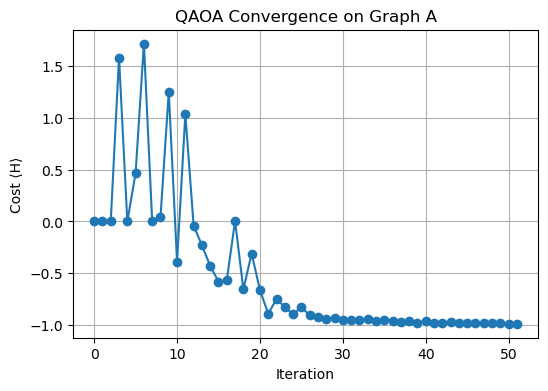

In [27]:
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(objective_func_vals, marker='o')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost ⟨H⟩")
ax.set_title("QAOA Convergence on Graph A")
ax.grid(True)
plt.show()


In [28]:
Path("results").mkdir(exist_ok=True)

with open("results/graph_a_params.json", "w") as f:
    json.dump({
        "optimal_params": result.x.tolist(),
        "final_cost": result.fun,
        "cost_trajectory": objective_func_vals
    }, f)

fig.savefig("results/graph_a_convergence.png", dpi=300)


## QAOA Parameter Transfer: Graph B (Perturbed from A)


### 7. Setup for Graph B
- Load saved results from Graph A
- Define helper function to run QAOA on a new graph
- Initialize Estimator for reuse

### 8. Graph B: MaxCut Formulation
- Create Graph B by removing one edge from Graph A
- Plot the perturbed graph for visual comparison

### 9. Convert to QUBO + Ising
- Use Qiskit Optimization to convert Graph B to a Quadratic Program
- Translate to Pauli-form Hamiltonian

### 10. QAOA Ansatz for Graph B
- Build QAOA circuit with the same number of repetitions (reps)
- Create a copy with `measure_all()` for visualization

### 11. QAOA Optimization on Graph B

#### 11A. Random Initialization
- Define cost function that logs cost at each iteration
- Run COBYLA starting from a random initial parameter vector
- Record final cost and cost trajectory

#### 11B. Transferred Initialization (from Graph A)
- Load optimal parameters from


### Graph B - Slightly perturbed Graph A

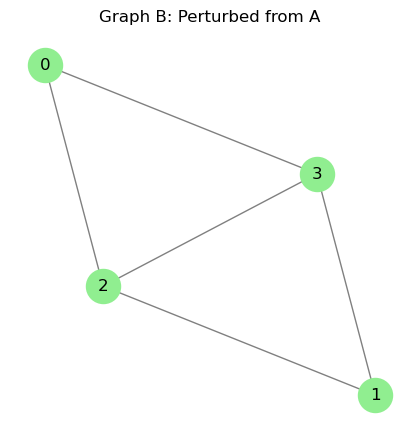

In [9]:
# Graph B: Remove one edge from Graph A
G_b = nx.complete_graph(4)
G_b.remove_edge(0, 1)  # slight perturbation
pos_b = nx.spring_layout(G_b, seed=42)

plt.figure(figsize=(4, 4))
nx.draw(G_b, pos_b, with_labels=True, node_color='lightgreen', node_size=600, edge_color='gray')
plt.title("Graph B: Perturbed from A")
plt.show()

### QUBO and Hamiltonian 

In [10]:
w_b = nx.adjacency_matrix(G_b).todense()
maxcut_b = Maxcut(w_b)
qp_b = maxcut_b.to_quadratic_program()

qubit_op_b, offset_b = qp_b.to_ising()

In [11]:
circuit_b = QAOAAnsatz(cost_operator=qubit_op_b, reps=reps)

In [13]:
objective_func_vals_rand = []
objective_func_vals_transfer = []

def cost_func_estimator_b(params, tracker):
    job = estimator.run([circuit_b], [qubit_op_b], [params])
    result = job.result()
    cost = result.values[0]
    tracker.append(cost)
    return cost

### QAOA - Random Init

In [14]:
init_params_rand = [np.pi, np.pi/2] * reps

result_rand = minimize(
    lambda p: cost_func_estimator_b(p, objective_func_vals_rand),
    x0=init_params_rand,
    method='COBYLA',
    tol=1e-2
)

### QAOA - parameter transfer

In [15]:
with open("results/graph_a_params.json", "r") as f:
    graph_a_data = json.load(f)

init_params_transfer = graph_a_data["optimal_params"]

result_transfer = minimize(
    lambda p: cost_func_estimator_b(p, objective_func_vals_transfer),
    x0=init_params_transfer,
    method='COBYLA',
    tol=1e-2
)

### Compare convergence

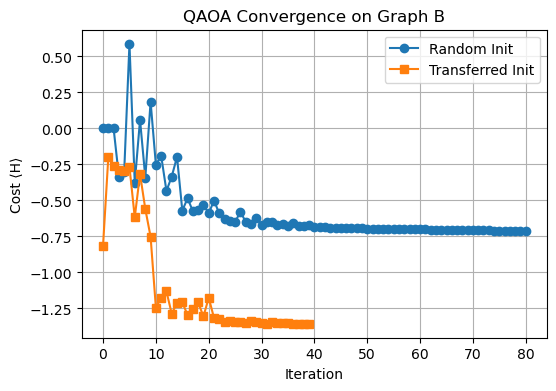

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(objective_func_vals_rand, label="Random Init", marker='o')
ax.plot(objective_func_vals_transfer, label="Transferred Init", marker='s')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost ⟨H⟩")
ax.set_title("QAOA Convergence on Graph B")
ax.legend()
ax.grid(True)
plt.show()

fig.savefig("results/graph_b_convergence_comparison.png")

### Log results

In [17]:
with open("results/graph_b_results.json", "w") as f:
    json.dump({
        "random_final_cost": result_rand.fun,
        "random_optimal_params": result_rand.x.tolist(),
        "random_cost_trajectory": objective_func_vals_rand,
        "transfer_final_cost": result_transfer.fun,
        "transfer_optimal_params": result_transfer.x.tolist(),
        "transfer_cost_trajectory": objective_func_vals_transfer
    }, f)
